##### Structure Output Format

**A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types. These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.**

**Why Use a Structured Output Agent?**

Controlled Responses: Ensures that the outputs follow a specific format, reducing ambiguity.
Data Validation: Useful when you want the model output to fit predefined structures, like for APIs or database entries.
Automation: Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [18]:
# Importing neccessary libraries and packages
import os
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import Graph,StateGraph,MessagesState,END
from langgraph.checkpoint import memory
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
load_dotenv()

True

In [6]:
# Setting the environment variables
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [60]:
# Initializing the LLM model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
llm=ChatGroq(model_name="Gemma2-9b-It")

In [95]:
# defining the schema for the output
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name:str = Field(description="State name of the city")
    state_capital:str = Field(description="State capital name of the city")
    counry_name:str = Field(description="Country name of the city")
    country_capital:str = Field(description="Country capital of the city")

In [105]:
# Defining the agentstate
# list of messages which should follow the CityDetails schema
class AgentState(MessagesState):
    final_response : CityDetails

In [106]:
# Tools

# get the city details based on given prompt
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    print("step from the tool get city details")
    travily_tool = TavilySearchResults()
    response = travily_tool.invoke(prompt)
    return response


# Bind the tools with llm and LLM will decide call the LLM or tool
tools = [get_city_details]
llm_with_tool = llm.bind_tools(tools)

In [98]:
# model with strcutured output
llm_with_structure_output = llm.with_structured_output(CityDetails)

In [134]:
# LLM / Agent
def call_model(state:AgentState):
    print(f" This is 1st step input from call model {state}")
    response = llm_with_tool.invoke(state['messages'])
    print(f"This is 2nd step response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Router
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"
    

# Respond
def respond(state: AgentState):
    print(f"This is 03rd step state from respond {state}")
    # messages = state['messages']
    
    # for msg in messages:
    #     print("Message : ",msg)
        
    response = llm_with_structure_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"This is 04th response from respond {response}")
    return {'final_response':response}

In [135]:
# Build the workflow 
workflow = StateGraph(AgentState)

# Addition of nodes 
workflow.add_node("LLM",call_model)
workflow.add_node("Tool",ToolNode(tools))
workflow.add_node("respond",respond)

# Addition of edges
workflow.add_conditional_edges(
    "LLM",
    should_continue,
    {
        "continue":"Tool",
        "respond":"respond"
    },
)

workflow.set_entry_point("LLM")
workflow.add_edge("Tool","LLM")
workflow.add_edge("respond", END)
app = workflow.compile()
# app

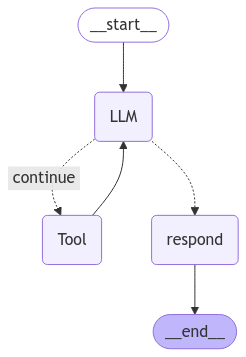

In [136]:
app

In [137]:
answer = app.invoke(input={"messages": ["Tell me about the city details for gwalior?"]})

 This is 1st step input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='da3cdc78-dc2e-4143-9750-6de95c6efae8')]}
This is 2nd step response from call model  content='' additional_kwargs={'tool_calls': [{'id': 'call_jg9p', 'function': {'arguments': '{"prompt":"gwalior"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 946, 'total_tokens': 1032, 'completion_time': 0.156363636, 'prompt_time': 0.030092786, 'queue_time': 0.023390864, 'total_time': 0.186456422}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-b9f06e44-ea83-4c42-835a-5647980e2a67-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'gwalior'}, 'id': 'call_jg9p', 'type': 'tool_call'}] usage_metadata={'input_tokens': 946, 'output_tokens': 86, 'total_tokens': 1032}
st

In [138]:
answer['final_response']

CityDetails(state_name='Madhya Pradesh', state_capital='Bhopal', counry_name='India', country_capital='New Delhi')

In [139]:
# Complete flow of the graph
# LLM -> decides(toolcall or not) --> If tool call --> (tool) --> again call LLM --> get response --> pass to respond for strcutured output